# Test Model on Multiple Datasets

This notebook evaluates a trained model on three test datasets:
- **Natural**: Uniformly random samples from [1, 10^13]
- **Cheat**: Numbers with prime factors only within the first 100 primes
- **Non-cheat**: Numbers with at least one prime factor outside the first 100 primes

It reports per-class performance for each dataset.

In [15]:
import sys
import os
import subprocess
import json
import re
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# to export, run 
# jupyter nbconvert test_performance_report.ipynb --to webpdf --no-input

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

## Configuration

Specify the model checkpoint and encoding to test:

In [16]:
# Model configuration
ENCODING = "interCRT100_with_n"  # Options: interCRT100, CRT100, interCRT100_with_n, CRT100_with_stats
TASK = "mu"  # Options: mu, musq
MODEL_DIR = "../models/model_interCRT100_with_n_natural/mu/1"  # Path to the directory containing the trained model
CHECKPOINT_NAME = "checkpoint"  # Name of checkpoint file (without .pth)

# Test datasets directory (will be created if needed)
INPUT_BASE_DIR = Path("../input")

# Results output directory
RESULTS_DIR = Path("../test_results") / f"{ENCODING}_{TASK}"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Test dataset types
DATASET_TYPES = ["natural", "cheat", "non_cheat"]

# Int2Int directory
INT2INT_DIR = Path("../Int2Int")

print(f"Testing model: {MODEL_DIR}/{CHECKPOINT_NAME}.pth")
print(f"Encoding: {ENCODING}")
print(f"Task: {TASK}")
print(f"Results will be saved to: {RESULTS_DIR}")

Testing model: ../models/model_interCRT100_with_n_natural/mu/1/checkpoint.pth
Encoding: interCRT100_with_n
Task: mu
Results will be saved to: ../test_results/interCRT100_with_n_mu


## Helper Functions

In [17]:
def get_encoding_params(encoding):
    """
    Get data_types parameter for each encoding.
    """
    encoding_map = {
        "interCRT100": "int[200]:range(-1,2)",
        "CRT100": "int[100]:range(-1,2)",
        "interCRT100_with_n": "int[201]:range(-1,2)",
        "CRT100_with_stats": "int[103]:range(-1,2)"
    }
    return encoding_map.get(encoding, "int[200]:range(-1,2)")


def get_test_data_path(encoding, dataset_type, task):
    """
    Construct the path to test data file.
    """
    if task == "mu":
        base_name = f"mu_{encoding}"
    elif task == "musq":
        base_name = f"musq_{encoding}"
    else:
        base_name = f"{task}_{encoding}"
    
    # Construct directory name
    input_dir = INPUT_BASE_DIR / f"input_dir_{encoding}_{dataset_type}"
    test_file = input_dir / f"{base_name}_{dataset_type}.txt.test"
    
    return test_file


def parse_log_output(log_text):
    """
    Parse the evaluation output to extract metrics.
    """
    # Find the __log__ JSON line
    log_match = re.search(r'__log__:({.+})', log_text)
    if log_match:
        try:
            return json.loads(log_match.group(1))
        except json.JSONDecodeError as e:
            print(f"Error parsing JSON: {e}")
            return None
    return None


def interpret_class_id(class_id, task):
    """
    Interpret class ID based on task type.
    """
    if task == 'mu':
        if class_id == '0':
            return 'μ(n) = 0'
        elif class_id == '1':
            return 'μ(n) = 1'
        elif class_id == '100':
            return 'μ(n) = -1'
        else:
            return f'Class {class_id}'
    elif task == 'musq':
        if class_id == '0':
            return 'μ²(n) = 0'
        elif class_id == '1':
            return 'μ²(n) = 1'
        else:
            return f'Class {class_id}'
    else:
        return f'Class {class_id}'


print("Helper functions loaded!")

Helper functions loaded!


## Check if Model Checkpoint Exists

In [18]:
checkpoint_path = Path(MODEL_DIR) / f"{CHECKPOINT_NAME}.pth"

if checkpoint_path.exists():
    print(f"✓ Checkpoint found: {checkpoint_path}")
else:
    print(f"✗ Checkpoint NOT found: {checkpoint_path}")
    print(f"\nAvailable files in {MODEL_DIR}:")
    model_dir_path = Path(MODEL_DIR)
    if model_dir_path.exists():
        for f in model_dir_path.iterdir():
            print(f"  - {f.name}")
    else:
        print(f"  Directory {MODEL_DIR} does not exist!")
    
    print("\n" + "="*80)
    print("NOTE: If no checkpoint exists, you need to:")
    print("1. Train a model with --save_periodic flag, OR")
    print("2. The model will auto-save 'best-valid_arithmetic_acc.pth' during training")
    print("3. Check the train.log to see if 'Saving best' messages appear")
    print("="*80)

✓ Checkpoint found: ../models/model_interCRT100_with_n_natural/mu/1/checkpoint.pth


## Check Test Data Files

In [19]:
print("Checking test data files:\n")
test_files = {}

for dataset_type in DATASET_TYPES:
    test_file = get_test_data_path(ENCODING, dataset_type, TASK)
    test_files[dataset_type] = test_file
    
    if test_file.exists():
        file_size = test_file.stat().st_size / (1024 * 1024)  # MB
        print(f"✓ {dataset_type:12s}: {test_file} ({file_size:.2f} MB)")
    else:
        print(f"✗ {dataset_type:12s}: {test_file} NOT FOUND")


Checking test data files:

✓ natural     : ../input/input_dir_interCRT100_with_n_natural/mu_interCRT100_with_n_natural.txt.test (107.67 MB)
✓ cheat       : ../input/input_dir_interCRT100_with_n_cheat/mu_interCRT100_with_n_cheat.txt.test (107.01 MB)
✓ non_cheat   : ../input/input_dir_interCRT100_with_n_non_cheat/mu_interCRT100_with_n_non_cheat.txt.test (107.67 MB)


## Run Evaluation on Each Test Dataset

In [ ]:
def run_evaluation(model_dir, checkpoint_name, test_data_path, encoding, task, output_file, eval_size=10000):
    """
    Run evaluation using the Int2Int training script with --eval_only flag.
    Uses --eval_verbose=2 to capture predictions for precision/recall/F1/confusion matrix.
    Returns both metrics dict and path to eval file with predictions.
    """
    data_types = get_encoding_params(encoding)
    checkpoint_path = Path(model_dir) / f"{checkpoint_name}.pth"
    
    # Create a temporary dump directory for evaluation output
    eval_dump_path = RESULTS_DIR / "eval_dump"
    eval_dump_path.mkdir(parents=True, exist_ok=True)
    
    cmd = [
        "python", str(INT2INT_DIR / "train.py"),
        "--eval_only", "True",
        "--reload_model", str(checkpoint_path.absolute()),
        "--eval_data", str(test_data_path.absolute()),
        "--eval_size", str(eval_size),
        "--data_types", data_types,
        "--operation", "data",
        "--cpu", "True",
        "--num_workers", "0",
        "--dump_path", str(eval_dump_path.absolute()),
        "--eval_verbose", "2",  # Capture all predictions for detailed metrics
    ]
    
    print(f"\nRunning command:")
    print(" ".join(cmd[:15]) + "...")
    print("\n" + "="*80)
    
    try:
        result = subprocess.run(
            cmd,
            capture_output=True,
            text=True,
            timeout=1200  # 20 minute timeout for verbose eval
        )
        
        # Save full output to file
        with open(output_file, 'w') as f:
            f.write("STDOUT:\n")
            f.write(result.stdout)
            f.write("\n\nSTDERR:\n")
            f.write(result.stderr)
        
        print(f"Full output saved to: {output_file}")
        
        # Parse metrics from output
        metrics = parse_log_output(result.stdout)
        if metrics is None:
            metrics = parse_log_output(result.stderr)
        
        # Find the eval output file with predictions
        eval_files = list(eval_dump_path.glob("eval.valid.arithmetic.*"))
        eval_file = eval_files[-1] if eval_files else None
        
        if result.returncode != 0:
            print(f"\n⚠ Warning: Command exited with code {result.returncode}")
            print("Last 30 lines of stderr:")
            print("\n".join(result.stderr.split("\n")[-30:]))
        
        return metrics, eval_file, result
        
    except subprocess.TimeoutExpired:
        print("\n✗ Evaluation timed out after 20 minutes")
        return None, None, None
    except Exception as e:
        print(f"\n✗ Error running evaluation: {e}")
        return None, None, None


print("Evaluation function ready!")

## Evaluate on Natural Dataset

In [ ]:
dataset_type = "natural"
test_file = test_files[dataset_type]
output_file = RESULTS_DIR / f"eval_{dataset_type}.log"

# Store eval files for later use in classification metrics
eval_files_map = {}

if not test_file.exists():
    print(f"✗ Test file not found: {test_file}")
    natural_metrics = None
elif not checkpoint_path.exists():
    print(f"✗ Checkpoint not found: {checkpoint_path}")
    natural_metrics = None
else:
    print(f"\n{'='*80}")
    print(f"EVALUATING ON NATURAL DATASET")
    print(f"{'='*80}")
    natural_metrics, eval_file, result = run_evaluation(
        MODEL_DIR, CHECKPOINT_NAME, test_file, ENCODING, TASK, output_file
    )
    eval_files_map['natural'] = eval_file
    
    if natural_metrics:
        print("\n✓ Evaluation completed successfully!")
        print(f"\nOverall Accuracy: {natural_metrics.get('valid_arithmetic_acc', 'N/A'):.2f}%")
    else:
        print("\n✗ Failed to parse metrics from evaluation output")

## Evaluate on Cheat Dataset

In [ ]:
dataset_type = "cheat"
test_file = test_files[dataset_type]
output_file = RESULTS_DIR / f"eval_{dataset_type}.log"

if not test_file.exists():
    print(f"✗ Test file not found: {test_file}")
    cheat_metrics = None
elif not checkpoint_path.exists():
    print(f"✗ Checkpoint not found: {checkpoint_path}")
    cheat_metrics = None
else:
    print(f"\n{'='*80}")
    print(f"EVALUATING ON CHEAT DATASET")
    print(f"{'='*80}")
    cheat_metrics, eval_file, result = run_evaluation(
        MODEL_DIR, CHECKPOINT_NAME, test_file, ENCODING, TASK, output_file
    )
    eval_files_map['cheat'] = eval_file
    
    if cheat_metrics:
        print("\n✓ Evaluation completed successfully!")
        print(f"\nOverall Accuracy: {cheat_metrics.get('valid_arithmetic_acc', 'N/A'):.2f}%")
    else:
        print("\n✗ Failed to parse metrics from evaluation output")

## Evaluate on Non-Cheat Dataset

In [ ]:
dataset_type = "non_cheat"
test_file = test_files[dataset_type]
output_file = RESULTS_DIR / f"eval_{dataset_type}.log"

if not test_file.exists():
    print(f"✗ Test file not found: {test_file}")
    non_cheat_metrics = None
elif not checkpoint_path.exists():
    print(f"✗ Checkpoint not found: {checkpoint_path}")
    non_cheat_metrics = None
else:
    print(f"\n{'='*80}")
    print(f"EVALUATING ON NON-CHEAT DATASET")
    print(f"{'='*80}")
    non_cheat_metrics, eval_file, result = run_evaluation(
        MODEL_DIR, CHECKPOINT_NAME, test_file, ENCODING, TASK, output_file
    )
    eval_files_map['non_cheat'] = eval_file
    
    if non_cheat_metrics:
        print("\n✓ Evaluation completed successfully!")
        print(f"\nOverall Accuracy: {non_cheat_metrics.get('valid_arithmetic_acc', 'N/A'):.2f}%")
    else:
        print("\n✗ Failed to parse metrics from evaluation output")

## Compile Results

In [24]:
# Collect all metrics
all_metrics = {
    'natural': natural_metrics,
    'cheat': cheat_metrics,
    'non_cheat': non_cheat_metrics
}

# Filter out None values
all_metrics = {k: v for k, v in all_metrics.items() if v is not None}

if not all_metrics:
    print("\n✗ No evaluation results available. Please check:")
    print("  1. Model checkpoint exists")
    print("  2. Test data files exist")
    print("  3. Evaluation ran without errors")
else:
    print(f"\n✓ Successfully evaluated on {len(all_metrics)} dataset(s)")
    
    # Save combined results
    results_json = RESULTS_DIR / "all_results.json"
    with open(results_json, 'w') as f:
        json.dump(all_metrics, f, indent=2)
    print(f"\nResults saved to: {results_json}")


✓ Successfully evaluated on 3 dataset(s)

Results saved to: ../test_results/interCRT100_with_n_mu/all_results.json


## Overall Performance Comparison

In [ ]:
if all_metrics:
    print("="*80)
    print("OVERALL PERFORMANCE SUMMARY")
    print("="*80)
    
    # Create summary table
    summary_data = []
    for dataset_type, metrics in all_metrics.items():
        summary_data.append({
            'Dataset': dataset_type.replace('_', '-').title(),
            'Accuracy (%)': metrics.get('valid_arithmetic_acc', 0),
            'Acc μ=0 (%)': metrics.get('valid_arithmetic_acc_0', 0),
            'Acc μ=1 (%)': metrics.get('valid_arithmetic_acc_1', 0),
            'Acc μ=-1 (%)': metrics.get('valid_arithmetic_acc_100', 0),
            'Perfect (%)': metrics.get('valid_arithmetic_perfect', 0),
            'Correct (%)': metrics.get('valid_arithmetic_correct', 0),
            'XE Loss': metrics.get('valid_arithmetic_xe_loss', 0)
        })
    
    summary_df = pd.DataFrame(summary_data)
    display(summary_df)
    
    # Save to CSV
    summary_csv = RESULTS_DIR / "overall_summary.csv"
    summary_df.to_csv(summary_csv, index=False)
    print(f"\nSummary saved to: {summary_csv}")
else:
    print("No metrics to display")

## Precision, Recall, F1, and Confusion Matrix

**Note:** The Int2Int evaluator provides per-class accuracy but not the full confusion matrix. To compute precision, recall, and F1 properly, we need to run a custom evaluation that captures predictions vs ground truth.

The following section runs a custom evaluation to extract predictions and compute these metrics.

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

def compute_classification_metrics(y_true, y_pred, task='mu'):
    """
    Compute precision, recall, F1, and confusion matrix.
    
    For μ task: classes are -1, 0, 1
    For μ² task: classes are 0, 1
    """
    if y_true is None or len(y_true) == 0:
        return None
    
    # Define class labels based on task
    if task == 'mu':
        labels = [-1, 0, 1]
        target_names = ['μ=-1', 'μ=0', 'μ=1']
    else:  # musq
        labels = [0, 1]
        target_names = ['μ²=0', 'μ²=1']
    
    # Filter to only valid predictions (in expected classes)
    valid_mask = np.isin(y_pred, labels)
    y_true_valid = y_true[valid_mask]
    y_pred_valid = y_pred[valid_mask]
    
    if len(y_true_valid) == 0:
        return None
    
    # Compute metrics
    metrics = {
        'precision_macro': precision_score(y_true_valid, y_pred_valid, labels=labels, average='macro', zero_division=0),
        'recall_macro': recall_score(y_true_valid, y_pred_valid, labels=labels, average='macro', zero_division=0),
        'f1_macro': f1_score(y_true_valid, y_pred_valid, labels=labels, average='macro', zero_division=0),
        'precision_weighted': precision_score(y_true_valid, y_pred_valid, labels=labels, average='weighted', zero_division=0),
        'recall_weighted': recall_score(y_true_valid, y_pred_valid, labels=labels, average='weighted', zero_division=0),
        'f1_weighted': f1_score(y_true_valid, y_pred_valid, labels=labels, average='weighted', zero_division=0),
        'confusion_matrix': confusion_matrix(y_true_valid, y_pred_valid, labels=labels),
        'classification_report': classification_report(y_true_valid, y_pred_valid, labels=labels, target_names=target_names, zero_division=0),
        'labels': labels,
        'target_names': target_names,
        'n_valid_predictions': len(y_true_valid),
        'n_invalid_predictions': len(y_true) - len(y_true_valid),
    }
    
    # Per-class metrics
    precision_per_class = precision_score(y_true_valid, y_pred_valid, labels=labels, average=None, zero_division=0)
    recall_per_class = recall_score(y_true_valid, y_pred_valid, labels=labels, average=None, zero_division=0)
    f1_per_class = f1_score(y_true_valid, y_pred_valid, labels=labels, average=None, zero_division=0)
    
    for i, label in enumerate(labels):
        metrics[f'precision_{label}'] = precision_per_class[i]
        metrics[f'recall_{label}'] = recall_per_class[i]
        metrics[f'f1_{label}'] = f1_per_class[i]
    
    return metrics


def parse_eval_file(eval_file):
    """
    Parse the eval.valid.arithmetic.* file to extract predictions and ground truth.
    
    Format:
    Equation N (correct/total)
    src=...
    tgt=['value']
    0/1 ['prediction']
    """
    y_true = []
    y_pred = []
    
    if eval_file is None or not Path(eval_file).exists():
        return None, None
    
    with open(eval_file, 'r') as f:
        lines = f.readlines()
    
    i = 0
    while i < len(lines):
        line = lines[i].strip()
        
        # Look for tgt= line
        if line.startswith('tgt='):
            # Extract ground truth
            # Format: tgt=['-1'] or tgt=['1'] or tgt=['0']
            tgt_match = re.search(r"tgt=\['?(-?\d+)'?\]", line)
            if tgt_match:
                true_val = int(tgt_match.group(1))
                
                # Next line should have prediction: "0/1 ['prediction']" or "0/1 prediction"
                if i + 1 < len(lines):
                    pred_line = lines[i + 1].strip()
                    # Match patterns like: "1 ['-1']" or "0 ['1']" or "1 -1"
                    pred_match = re.search(r"^[01]\s+\[?'?(-?\d+)'?\]?", pred_line)
                    if pred_match:
                        pred_val = int(pred_match.group(1))
                        y_true.append(true_val)
                        y_pred.append(pred_val)
        i += 1
    
    if len(y_true) == 0:
        return None, None
    
    return np.array(y_true), np.array(y_pred)


print("Classification metrics and parsing functions loaded!")

## Compute Classification Metrics from Evaluation Results

Use the predictions captured from the evaluation runs above:

In [ ]:
# Compute classification metrics from the evaluation results already captured
detailed_metrics = {}

for dataset_type in DATASET_TYPES:
    eval_file = eval_files_map.get(dataset_type)
    
    if eval_file is None:
        print(f"Skipping {dataset_type}: no eval file available")
        continue
    
    print(f"\n{'='*80}")
    print(f"PARSING PREDICTIONS: {dataset_type.upper()}")
    print(f"{'='*80}")
    
    print(f"Parsing predictions from: {eval_file}")
    y_true, y_pred = parse_eval_file(eval_file)
    
    if y_true is not None and len(y_true) > 0:
        print(f"Extracted {len(y_true)} predictions")
        metrics = compute_classification_metrics(y_true, y_pred, task=TASK)
        if metrics:
            detailed_metrics[dataset_type] = {
                'metrics': metrics,
                'y_true': y_true,
                'y_pred': y_pred
            }
            print(f"Metrics computed successfully!")
        else:
            print("Failed to compute metrics")
    else:
        print("No predictions extracted from eval file")

print(f"\n{'='*80}")
print(f"Classification metrics computed for {len(detailed_metrics)} dataset(s)")
print(f"{'='*80}")

## Classification Report: Precision, Recall, F1

In [ ]:
if detailed_metrics:
    for dataset_type, data in detailed_metrics.items():
        metrics = data['metrics']
        
        print(f"\n{'='*80}")
        print(f"CLASSIFICATION REPORT: {dataset_type.upper()}")
        print(f"{'='*80}")
        print(f"\nSamples evaluated: {metrics['n_valid_predictions']}")
        print(f"Invalid predictions: {metrics['n_invalid_predictions']}")
        print(f"\n{metrics['classification_report']}")
        
        # Summary metrics table
        print("\nSummary Metrics:")
        print("-" * 50)
        print(f"{'Metric':<25} {'Macro':<12} {'Weighted':<12}")
        print("-" * 50)
        print(f"{'Precision':<25} {metrics['precision_macro']:<12.4f} {metrics['precision_weighted']:<12.4f}")
        print(f"{'Recall':<25} {metrics['recall_macro']:<12.4f} {metrics['recall_weighted']:<12.4f}")
        print(f"{'F1-Score':<25} {metrics['f1_macro']:<12.4f} {metrics['f1_weighted']:<12.4f}")
        print("-" * 50)
else:
    print("No detailed metrics available. Run the detailed evaluation cells above.")

## Confusion Matrices

In [ ]:
if detailed_metrics:
    n_datasets = len(detailed_metrics)
    fig, axes = plt.subplots(1, n_datasets, figsize=(6*n_datasets, 5))
    
    if n_datasets == 1:
        axes = [axes]
    
    for ax, (dataset_type, data) in zip(axes, detailed_metrics.items()):
        metrics = data['metrics']
        cm = metrics['confusion_matrix']
        labels = metrics['target_names']
        
        # Plot confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=labels, yticklabels=labels, ax=ax,
                   cbar_kws={'shrink': 0.8})
        ax.set_xlabel('Predicted', fontsize=12, fontweight='bold')
        ax.set_ylabel('Actual', fontsize=12, fontweight='bold')
        ax.set_title(f'Confusion Matrix: {dataset_type.replace("_", "-").title()}\n'
                    f'(n={metrics["n_valid_predictions"]})', 
                    fontsize=13, fontweight='bold')
    
    plt.tight_layout()
    
    # Save figure
    fig_path = RESULTS_DIR / "confusion_matrices.png"
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"Figure saved to: {fig_path}")
    
    plt.show()
else:
    print("No detailed metrics available for confusion matrix visualization.")

In [ ]:
# Normalized confusion matrices (show percentages)
if detailed_metrics:
    n_datasets = len(detailed_metrics)
    fig, axes = plt.subplots(1, n_datasets, figsize=(6*n_datasets, 5))
    
    if n_datasets == 1:
        axes = [axes]
    
    for ax, (dataset_type, data) in zip(axes, detailed_metrics.items()):
        metrics = data['metrics']
        cm = metrics['confusion_matrix']
        labels = metrics['target_names']
        
        # Normalize by row (actual class)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm_normalized = np.nan_to_num(cm_normalized)  # Handle division by zero
        
        # Plot normalized confusion matrix
        sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', 
                   xticklabels=labels, yticklabels=labels, ax=ax,
                   cbar_kws={'shrink': 0.8}, vmin=0, vmax=1)
        ax.set_xlabel('Predicted', fontsize=12, fontweight='bold')
        ax.set_ylabel('Actual', fontsize=12, fontweight='bold')
        ax.set_title(f'Normalized Confusion Matrix: {dataset_type.replace("_", "-").title()}\n'
                    f'(Row-normalized, n={metrics["n_valid_predictions"]})', 
                    fontsize=13, fontweight='bold')
    
    plt.tight_layout()
    
    # Save figure
    fig_path = RESULTS_DIR / "confusion_matrices_normalized.png"
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"Figure saved to: {fig_path}")
    
    plt.show()
else:
    print("No detailed metrics available.")

## Precision, Recall, F1 Comparison Across Datasets

In [ ]:
if detailed_metrics:
    # Create comparison DataFrame
    comparison_data = []
    
    for dataset_type, data in detailed_metrics.items():
        metrics = data['metrics']
        comparison_data.append({
            'Dataset': dataset_type.replace('_', '-').title(),
            'Precision (Macro)': metrics['precision_macro'],
            'Recall (Macro)': metrics['recall_macro'],
            'F1 (Macro)': metrics['f1_macro'],
            'Precision (Weighted)': metrics['precision_weighted'],
            'Recall (Weighted)': metrics['recall_weighted'],
            'F1 (Weighted)': metrics['f1_weighted'],
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    display(comparison_df.round(4))
    
    # Save to CSV
    comparison_csv = RESULTS_DIR / "classification_metrics_comparison.csv"
    comparison_df.to_csv(comparison_csv, index=False)
    print(f"\nSaved to: {comparison_csv}")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Macro metrics
    ax = axes[0]
    x = np.arange(len(comparison_df))
    width = 0.25
    
    bars1 = ax.bar(x - width, comparison_df['Precision (Macro)'], width, label='Precision', color='#3498db')
    bars2 = ax.bar(x, comparison_df['Recall (Macro)'], width, label='Recall', color='#2ecc71')
    bars3 = ax.bar(x + width, comparison_df['F1 (Macro)'], width, label='F1', color='#e74c3c')
    
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('Macro-Averaged Metrics by Dataset', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(comparison_df['Dataset'])
    ax.legend()
    ax.set_ylim([0, 1.1])
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.2f}', ha='center', va='bottom', fontsize=9)
    
    # Weighted metrics
    ax = axes[1]
    bars1 = ax.bar(x - width, comparison_df['Precision (Weighted)'], width, label='Precision', color='#3498db')
    bars2 = ax.bar(x, comparison_df['Recall (Weighted)'], width, label='Recall', color='#2ecc71')
    bars3 = ax.bar(x + width, comparison_df['F1 (Weighted)'], width, label='F1', color='#e74c3c')
    
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('Weighted-Averaged Metrics by Dataset', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(comparison_df['Dataset'])
    ax.legend()
    ax.set_ylim([0, 1.1])
    ax.grid(True, alpha=0.3, axis='y')
    
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.2f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    
    fig_path = RESULTS_DIR / "precision_recall_f1_comparison.png"
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"Figure saved to: {fig_path}")
    
    plt.show()
else:
    print("No detailed metrics available.")

## Per-Class Precision, Recall, F1

In [ ]:
if detailed_metrics:
    # Per-class metrics for each dataset
    if TASK == 'mu':
        classes = [-1, 0, 1]
        class_names = ['μ=-1', 'μ=0', 'μ=1']
    else:
        classes = [0, 1]
        class_names = ['μ²=0', 'μ²=1']
    
    for dataset_type, data in detailed_metrics.items():
        metrics = data['metrics']
        
        print(f"\n{'='*80}")
        print(f"PER-CLASS METRICS: {dataset_type.upper()}")
        print(f"{'='*80}")
        
        # Create per-class table
        per_class_data = []
        for label, name in zip(classes, class_names):
            per_class_data.append({
                'Class': name,
                'Precision': metrics.get(f'precision_{label}', 0),
                'Recall': metrics.get(f'recall_{label}', 0),
                'F1-Score': metrics.get(f'f1_{label}', 0),
            })
        
        per_class_df = pd.DataFrame(per_class_data)
        display(per_class_df.round(4))
        
        # Save per-class metrics
        per_class_csv = RESULTS_DIR / f"per_class_metrics_{dataset_type}.csv"
        per_class_df.to_csv(per_class_csv, index=False)
        print(f"Saved to: {per_class_csv}")
else:
    print("No detailed metrics available.")

## Save All Detailed Metrics

In [ ]:
if detailed_metrics:
    # Save all metrics to JSON (excluding numpy arrays)
    save_metrics = {}
    for dataset_type, data in detailed_metrics.items():
        metrics = data['metrics'].copy()
        # Convert confusion matrix to list for JSON serialization
        metrics['confusion_matrix'] = metrics['confusion_matrix'].tolist()
        save_metrics[dataset_type] = metrics
    
    metrics_json = RESULTS_DIR / "detailed_classification_metrics.json"
    with open(metrics_json, 'w') as f:
        json.dump(save_metrics, f, indent=2)
    print(f"All detailed metrics saved to: {metrics_json}")
    
    # Also save predictions for further analysis
    for dataset_type, data in detailed_metrics.items():
        pred_file = RESULTS_DIR / f"predictions_{dataset_type}.npz"
        np.savez(pred_file, y_true=data['y_true'], y_pred=data['y_pred'])
        print(f"Predictions saved to: {pred_file}")
else:
    print("No detailed metrics to save.")

## Visualization: Overall Performance Comparison

Figure saved to: ../test_results/interCRT100_with_n_mu/overall_comparison.png


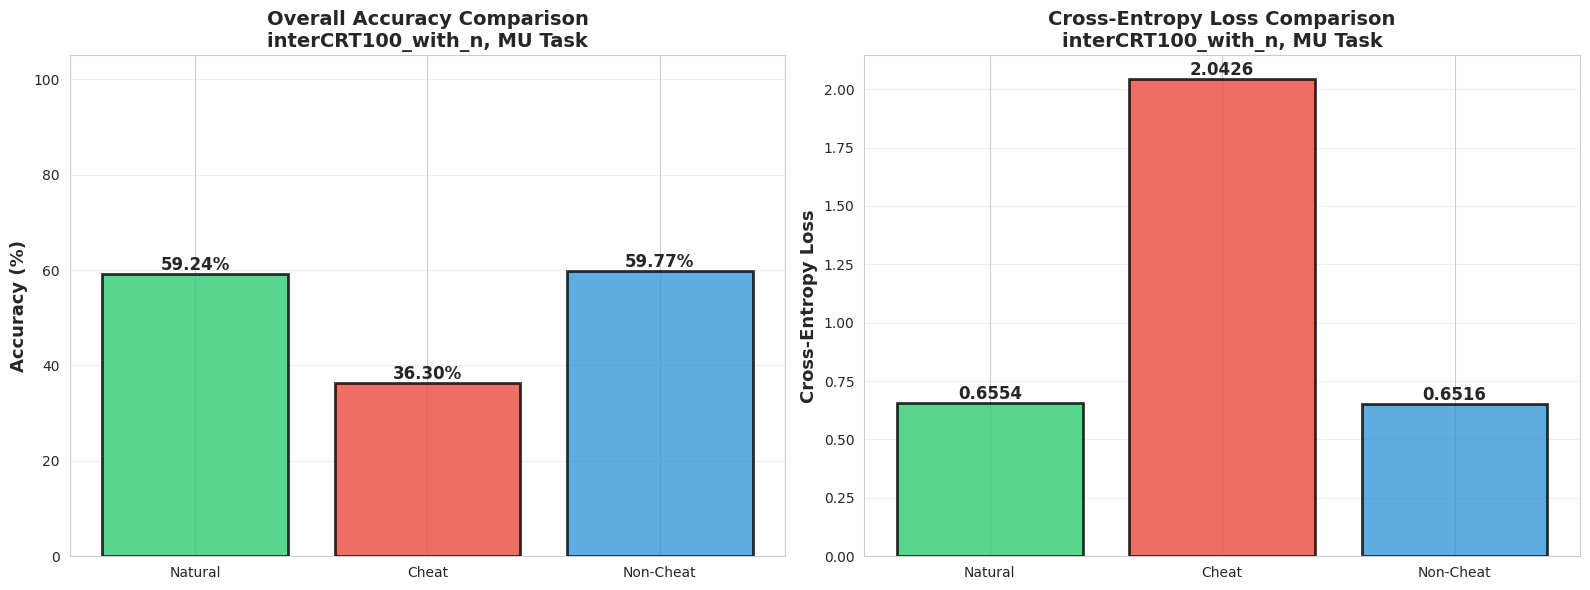

In [26]:
if all_metrics and len(all_metrics) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Accuracy comparison
    ax = axes[0]
    datasets = [k.replace('_', '-').title() for k in all_metrics.keys()]
    accuracies = [v.get('valid_arithmetic_acc', 0) for v in all_metrics.values()]
    colors = ['#2ecc71', '#e74c3c', '#3498db']
    
    bars = ax.bar(datasets, accuracies, color=colors[:len(datasets)], alpha=0.8, edgecolor='black', linewidth=2)
    
    # Add value labels
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{acc:.2f}%',
               ha='center', va='bottom', fontweight='bold', fontsize=12)
    
    ax.set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
    ax.set_title(f'Overall Accuracy Comparison\n{ENCODING}, {TASK.upper()} Task', 
                fontsize=14, fontweight='bold')
    ax.set_ylim([0, 105])
    ax.grid(True, alpha=0.3, axis='y')
    
    # Plot 2: XE Loss comparison
    ax = axes[1]
    losses = [v.get('valid_arithmetic_xe_loss', 0) for v in all_metrics.values()]
    
    bars = ax.bar(datasets, losses, color=colors[:len(datasets)], alpha=0.8, edgecolor='black', linewidth=2)
    
    # Add value labels
    for bar, loss in zip(bars, losses):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{loss:.4f}',
               ha='center', va='bottom', fontweight='bold', fontsize=12)
    
    ax.set_ylabel('Cross-Entropy Loss', fontsize=13, fontweight='bold')
    ax.set_title(f'Cross-Entropy Loss Comparison\n{ENCODING}, {TASK.upper()} Task', 
                fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    
    # Save figure
    fig_path = RESULTS_DIR / "overall_comparison.png"
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"Figure saved to: {fig_path}")
    
    plt.show()
else:
    print("No metrics to visualize")

## Visualization: Per-Class Performance Comparison

Figure saved to: ../test_results/interCRT100_with_n_mu/per_class_comparison.png


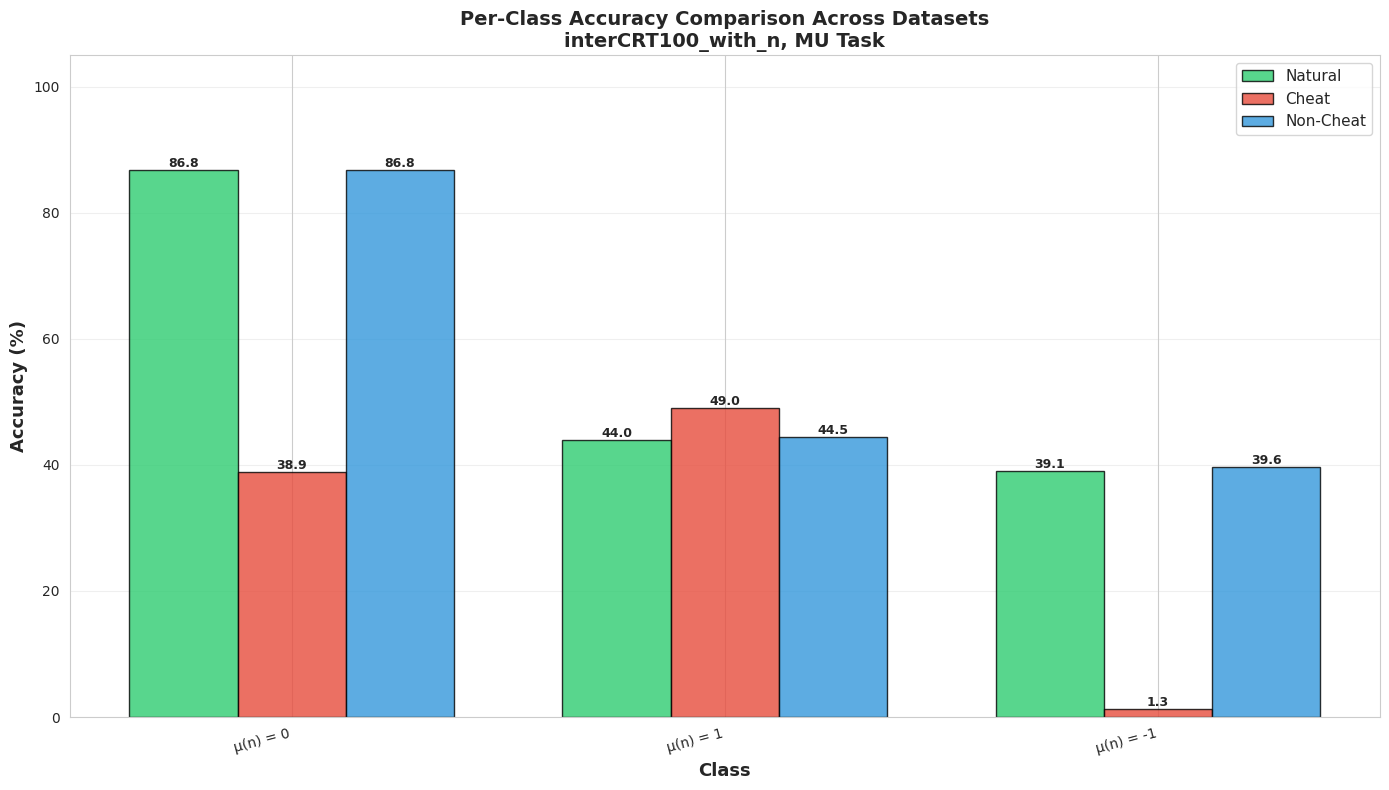

In [27]:
if all_metrics:
    # Collect per-class data for all datasets
    class_comparison = {}
    
    for dataset_type, metrics in all_metrics.items():
        for key, value in metrics.items():
            if key.startswith('valid_arithmetic_acc_'):
                class_id = key.split('_')[-1]
                if class_id not in ['d1', 'd2', 'd3']:
                    if class_id not in class_comparison:
                        class_comparison[class_id] = {}
                    class_comparison[class_id][dataset_type] = value
    
    if class_comparison:
        # Create DataFrame for plotting
        plot_data = []
        for class_id, datasets in class_comparison.items():
            for dataset_type, acc in datasets.items():
                plot_data.append({
                    'Class': interpret_class_id(class_id, TASK),
                    'Dataset': dataset_type.replace('_', '-').title(),
                    'Accuracy': acc
                })
        
        plot_df = pd.DataFrame(plot_data)
        
        # Create grouped bar chart
        fig, ax = plt.subplots(figsize=(14, 8))
        
        # Get unique classes and datasets
        classes = plot_df['Class'].unique()
        datasets = plot_df['Dataset'].unique()
        
        x = np.arange(len(classes))
        width = 0.25
        colors = ['#2ecc71', '#e74c3c', '#3498db']
        
        # Plot bars for each dataset
        for i, dataset in enumerate(datasets):
            dataset_data = plot_df[plot_df['Dataset'] == dataset]
            values = [dataset_data[dataset_data['Class'] == c]['Accuracy'].values[0] 
                     if len(dataset_data[dataset_data['Class'] == c]) > 0 else 0 
                     for c in classes]
            
            offset = width * (i - len(datasets)/2 + 0.5)
            bars = ax.bar(x + offset, values, width, label=dataset, 
                         color=colors[i % len(colors)], alpha=0.8, edgecolor='black')
            
            # Add value labels
            for bar, val in zip(bars, values):
                if val > 0:
                    height = bar.get_height()
                    ax.text(bar.get_x() + bar.get_width()/2., height,
                           f'{val:.1f}',
                           ha='center', va='bottom', fontsize=9, fontweight='bold')
        
        ax.set_xlabel('Class', fontsize=13, fontweight='bold')
        ax.set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
        ax.set_title(f'Per-Class Accuracy Comparison Across Datasets\n{ENCODING}, {TASK.upper()} Task',
                    fontsize=14, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(classes, rotation=15, ha='right')
        ax.legend(fontsize=11)
        ax.set_ylim([0, 105])
        ax.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        
        # Save figure
        fig_path = RESULTS_DIR / "per_class_comparison.png"
        plt.savefig(fig_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to: {fig_path}")
        
        plt.show()
    else:
        print("No per-class metrics to visualize")
else:
    print("No metrics to visualize")

## Manual Inspection: Sample Predictions from Each Test Set

Randomly select 20 samples from each test dataset and display the number, true Mobius value, and model prediction.

In [ ]:
# To get the actual number n, we need to read from the original test files
# and match with the eval output order

def read_test_file_numbers(test_file_path, encoding, n_lines=10000):
    """
    Read the test file and extract the original numbers.
    For interCRT100_with_n encoding, n is the last element in the input.
    For other encodings, we can't directly recover n from the CRT representation.
    """
    numbers = []
    
    if not Path(test_file_path).exists():
        return None
    
    with open(test_file_path, 'r') as f:
        for i, line in enumerate(f):
            if i >= n_lines:
                break
            
            parts = line.strip().split('\t')
            if len(parts) < 2:
                continue
            
            input_part = parts[0]
            output_part = parts[1]
            
            # Try to extract n based on encoding
            if 'with_n' in encoding:
                # For interCRT100_with_n, the last token before output is n
                tokens = input_part.split()
                # Find the last numeric token (n is appended at the end)
                # Format: V201 N1 P+ 0 N1 P+ 2 ... N13 P+ <n>
                # The n value is encoded, need to decode
                last_tokens = tokens[-3:]  # e.g., ['N13', 'P+', '1234567890123']
                if len(last_tokens) >= 1:
                    try:
                        # The number might be split into parts like "N13 P+ 123"
                        # Reconstruct the number from the encoded format
                        n_str = ""
                        for t in reversed(tokens):
                            if t.startswith('V'):
                                break
                            if t.startswith('N') or t.startswith('P'):
                                continue
                            n_str = t + n_str
                        if n_str:
                            numbers.append(int(n_str))
                        else:
                            numbers.append(None)
                    except:
                        numbers.append(None)
            else:
                # For other encodings, we can't easily recover n
                numbers.append(None)
    
    return numbers

# Try to get numbers for each dataset
test_numbers = {}
for dataset_type in DATASET_TYPES:
    test_file = test_files.get(dataset_type)
    if test_file and test_file.exists():
        nums = read_test_file_numbers(test_file, ENCODING)
        if nums:
            test_numbers[dataset_type] = nums
            print(f"{dataset_type}: loaded {len(nums)} numbers")
        else:
            print(f"{dataset_type}: could not load numbers")
    else:
        print(f"{dataset_type}: test file not found")

In [ ]:
# Display 20 random samples from each dataset with n, true μ(n), predicted μ(n)
N_SAMPLES_DISPLAY = 20

print("="*100)
print("SAMPLE PREDICTIONS FROM EACH TEST SET")
print("="*100)

all_samples = {}

for dataset_type in DATASET_TYPES:
    if dataset_type not in detailed_metrics:
        print(f"\nSkipping {dataset_type}: no predictions available")
        continue
    
    data = detailed_metrics[dataset_type]
    y_true = data['y_true']
    y_pred = data['y_pred']
    numbers = test_numbers.get(dataset_type, [None] * len(y_true))
    
    # Randomly select indices
    np.random.seed(42 + hash(dataset_type) % 1000)  # Different seed per dataset
    n_available = min(len(y_true), len(numbers))
    n_select = min(N_SAMPLES_DISPLAY, n_available)
    selected_indices = np.random.choice(n_available, size=n_select, replace=False)
    selected_indices = sorted(selected_indices)
    
    print(f"\n{'='*100}")
    print(f"DATASET: {dataset_type.upper()} (showing {n_select} random samples)")
    print("="*100)
    
    # Create table
    sample_data = []
    for idx in selected_indices:
        n_val = numbers[idx] if idx < len(numbers) else None
        true_mu = y_true[idx]
        pred_mu = y_pred[idx]
        correct = "Yes" if true_mu == pred_mu else "No"
        sample_data.append({
            'n': n_val if n_val else f"(sample {idx})",
            'True μ(n)': true_mu,
            'Predicted μ(n)': pred_mu,
            'Correct': correct
        })
    
    sample_df = pd.DataFrame(sample_data)
    all_samples[dataset_type] = sample_df
    
    # Summary
    n_correct = sum(1 for s in sample_data if s['Correct'] == 'Yes')
    print(f"Correct: {n_correct}/{n_select} ({100*n_correct/n_select:.1f}%)\n")
    
    display(sample_df)

print(f"\n{'='*100}")